In [23]:
%%bash
pip3 install gym[classic_control]
pip3 install gymnasium

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [24]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make('CartPole-v1')

is_ipython = 'inline' in matplotlib.get_backend()

if is_ipython:
  from IPython import display

plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

print(torch.cuda.is_available())

False


In [25]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
  def __init__(self, capacity):
    self.memory = deque([], maxlen= capacity)

  def push(self, *args):
    '''transition 저장'''
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

In [26]:
class DQN(nn.Module):
  def __init__(self, n_observations, n_actions):
    super(DQN, self).__init__()
    self.layer1 = nn.Linear(n_observations, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, n_actions)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    return self.layer3(x)



In [27]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n
#print(n_actions)

state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr = LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
  global steps_done
  sample = random.random()
  eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

  steps_done += 1
  if sample > eps_threshold:
    with torch.no_grad():
      return policy_net(state).max(1)[1].view(1,1)
  else:
    return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(show_result=False):
  plt.figure(1)
  durations_t = torch.tensor(episode_durations, dtype=torch.float)

  if show_result:
    plt.title('Result')
  else:
    plt.clf()
    plt.title('Training...')
  plt.xlabel('Episode')
  plt.ylabel('Duration')
  plt.plot(durations_t.numpy())

  if len(durations_t) >= 100:
    means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99), means))
    plt.plot(means.numpy())

  plt.pause(0.001)
  if is_ipython:
    if not show_result:
      display.display(plt.gcf())
      display.clear_output(wait=True)
    else:
      display.display(plt.gcf())


def optimize_model():
  if len(memory) < BATCH_SIZE:
    return

  transitions = memory.sample(BATCH_SIZE)

  batch = Transition(*zip(*transitions))

  non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)

  non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)

  state_action_values = policy_net(state_batch).gather(1, action_batch)

  next_state_values = torch.zeros(BATCH_SIZE, device=device)
  with torch.no_grad():
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

  expected_state_action_values = (next_state_values * GAMMA) + reward_batch

  criterion = nn.SmoothL1Loss()
  loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

  optimizer.zero_grad()
  loss.backward()

  torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
  optimizer.step()





Complete


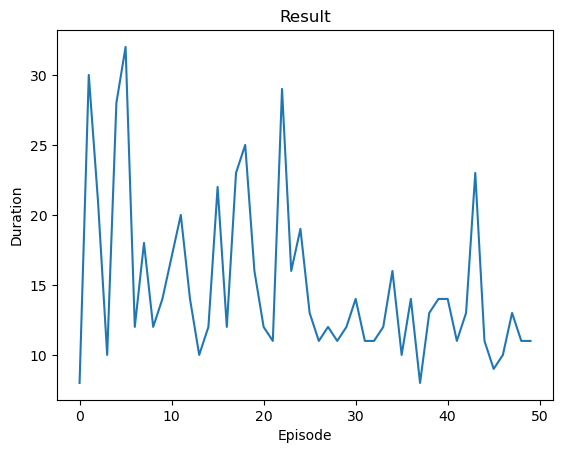

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [28]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # 환경과 상태 초기화
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # (정책 네트워크에서) 최적화 한단계 수행
        optimize_model()

        # 목표 네트워크의 가중치를 소프트 업데이트
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()